## 1 Data Preparation for Sentiment Classification of Reviews on Top 250 Movies

### 1.1 File load and train_val_test split

In [ ]:
# Import all necessary libraries for data processing, NLP, and machine learning
import collections
import numpy as np
import pandas as pd
import re
import random
import inspect
import os
from vaderSentiment import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from scipy.sparse import hstack
from argparse import Namespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from xgboost import XGBClassifier
import xgboost as xgb

[nltk_data] Downloading package punkt to /Users/luhui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luhui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luhui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/luhui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Define configuration parameters for the analysis
args = Namespace(                                 # Create key, value pairs, and access values later on, e.g., args.seed
    input_dataset_csv="data/movies_reviews.csv",
    train_proportion=0.7,
    test_proportion=0.3,
    seed=6752
)

In [ ]:
# Read raw data from CSV file
df = pd.read_csv(args.input_dataset_csv, header=0) # no header in the file

In [ ]:
# Display first few rows of the dataset
df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,movie_imdb_id,movie_url,review_title,review_rating,review_content
0,1,The Shawshank Redemption,1994,United States,9.3,Drama,tt0111161,https://www.imdb.com/title/tt0111161/,Some birds aren't meant to be caged.,10.0,The Shawshank Redemption is written and direct...
1,1,The Shawshank Redemption,1994,United States,9.3,Drama,tt0111161,https://www.imdb.com/title/tt0111161/,An incredible movie. One that lives with you.,10.0,It is no wonder that the film has such a high ...
2,1,The Shawshank Redemption,1994,United States,9.3,Drama,tt0111161,https://www.imdb.com/title/tt0111161/,Don't Rent Shawshank.,10.0,I'm trying to save you money; this is the last...
3,1,The Shawshank Redemption,1994,United States,9.3,Drama,tt0111161,https://www.imdb.com/title/tt0111161/,A classic piece of unforgettable film-making.,10.0,"In its Oscar year, Shawshank Redemption (writt..."
4,1,The Shawshank Redemption,1994,United States,9.3,Drama,tt0111161,https://www.imdb.com/title/tt0111161/,This is How Movies Should Be Made,10.0,This movie is not your ordinary Hollywood flic...


In [ ]:
# Check column names in the dataset
df.columns

Index(['movie_rank', 'movie_title', 'movie_year', 'movie_country',
       'movie_rating', 'movie_genre', 'movie_imdb_id', 'movie_url',
       'review_title', 'review_rating', 'review_content'],
      dtype='object')

In [ ]:
# Select relevant columns for analysis and display dataset info
df = df[['movie_rank', 'movie_title', 'movie_year', 'movie_country',
       'movie_rating', 'movie_genre', 'review_title',
       'review_rating', 'review_content']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136957 entries, 0 to 136956
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movie_rank      136957 non-null  int64  
 1   movie_title     136957 non-null  object 
 2   movie_year      136957 non-null  int64  
 3   movie_country   136957 non-null  object 
 4   movie_rating    136957 non-null  float64
 5   movie_genre     136957 non-null  object 
 6   review_title    136954 non-null  object 
 7   review_rating   127382 non-null  float64
 8   review_content  136957 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 9.4+ MB


In [ ]:
# Check for missing values in the dataset
df.isna().sum()

movie_rank           0
movie_title          0
movie_year           0
movie_country        0
movie_rating         0
movie_genre          0
review_title         3
review_rating     9575
review_content       0
dtype: int64

In [ ]:
# Remove rows with missing review ratings or titles
df = df[df['review_rating'].isna() == False]
df = df[df['review_title'].isna() == False]
df.isna().sum()

movie_rank        0
movie_title       0
movie_year        0
movie_country     0
movie_rating      0
movie_genre       0
review_title      0
review_rating     0
review_content    0
dtype: int64

In [ ]:
# Create sentiment labels based on review ratings (0-4: negative, 5-7: neutral, 8-10: positive)
df['label'] = pd.cut(df['review_rating'],bins=[0,4,7,10],labels=['negative','neutral','positive'], right=True)

In [ ]:
# Check distribution of sentiment labels
df['label'].value_counts()

label
positive    94331
neutral     24314
negative     8734
Name: count, dtype: int64

In [ ]:
# Group data by sentiment labels for stratified sampling
by_label = collections.defaultdict(list)
for _,row in df.iterrows():
    by_label[row.label].append(row.to_dict())

by_label.keys()

dict_keys(['positive', 'neutral', 'negative'])

In [ ]:
# Split dataset into train, validate and test sets with stratified sampling
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_label.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list) 

In [ ]:
# Convert split data list back to DataFrame and check split distribution
final_df = pd.DataFrame(final_list)
final_df.split.value_counts()

split
train    89163
test     38213
Name: count, dtype: int64

### 1.2 Data preprocessing

#### Remove URL, @ ,punctuation and any other special characters from statements

In [ ]:
# Define text cleaning function to remove URLs, mentions, and special characters
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s\']', '', text) 
    return text.strip()
    
# Apply text cleaning to review titles and content
final_df['review_title'] = final_df.review_title.apply(clean_text)
final_df['review_content'] = final_df.review_content.apply(clean_text) 
final_df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,review_title,review_rating,review_content,label,split
0,235,Rush,2013,United Kingdom,8.1,"Biography, Drama, Sport",i didn't really like it,3.0,the scenes with nikki lauda in are absolutely ...,negative,train
1,155,Finding Nemo,2003,United States,8.2,"Animation, Adventure, Comedy",i was just so bored,1.0,judging from the reviews i just read of findin...,negative,train
2,227,Platoon,1986,United States,8.1,"Drama, War",fake,1.0,the film has as its core the supposed moral ri...,negative,train
3,166,Chinatown,1974,United States,8.1,"Drama, Mystery, Thriller",highly overrated,4.0,to me chinatown is a mediocre film noir i love...,negative,train
4,76,Good Will Hunting,1997,United States,8.3,"Drama, Romance",one of the worst,1.0,um maybe i just didn't get it but everyone thi...,negative,train


In [ ]:
# Tokenize text by splitting into words

final_df['review_title'] = final_df.review_title.apply(lambda x: x.split(' '))
final_df['review_content'] = final_df.review_content.apply(lambda x: x.split(' '))
final_df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,review_title,review_rating,review_content,label,split
0,235,Rush,2013,United Kingdom,8.1,"Biography, Drama, Sport","[i, didn't, really, like, it]",3.0,"[the, scenes, with, nikki, lauda, in, are, abs...",negative,train
1,155,Finding Nemo,2003,United States,8.2,"Animation, Adventure, Comedy","[i, was, just, so, bored]",1.0,"[judging, from, the, reviews, i, just, read, o...",negative,train
2,227,Platoon,1986,United States,8.1,"Drama, War",[fake],1.0,"[the, film, has, as, its, core, the, supposed,...",negative,train
3,166,Chinatown,1974,United States,8.1,"Drama, Mystery, Thriller","[highly, overrated]",4.0,"[to, me, chinatown, is, a, mediocre, film, noi...",negative,train
4,76,Good Will Hunting,1997,United States,8.3,"Drama, Romance","[one, of, the, worst]",1.0,"[um, maybe, i, just, didn't, get, it, but, eve...",negative,train


In [ ]:
# Define function to remove stopwords from tokenized text
def filter_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]  

# Apply stopword filtering to review titles and content
final_df['review_title'] = final_df.review_title.apply(filter_stopwords)
final_df['review_content'] = final_df.review_content.apply(filter_stopwords)
final_df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,review_title,review_rating,review_content,label,split
0,235,Rush,2013,United Kingdom,8.1,"Biography, Drama, Sport","[really, like]",3.0,"[scenes, nikki, lauda, absolutely, excellent, ...",negative,train
1,155,Finding Nemo,2003,United States,8.2,"Animation, Adventure, Comedy",[bored],1.0,"[judging, reviews, read, finding, nemo, looks,...",negative,train
2,227,Platoon,1986,United States,8.1,"Drama, War",[fake],1.0,"[film, core, supposed, moral, rift, two, funda...",negative,train
3,166,Chinatown,1974,United States,8.1,"Drama, Mystery, Thriller","[highly, overrated]",4.0,"[chinatown, mediocre, film, noir, love, mister...",negative,train
4,76,Good Will Hunting,1997,United States,8.3,"Drama, Romance","[one, worst]",1.0,"[um, maybe, get, everyone, thinks, freak, soul...",negative,train


#### Stemming and Lemming

In [ ]:
# Define functions for stemming and lemmatization
def stem_words(word_list):
    """Stem words in list of tokenized words"""
    stemmer = PorterStemmer()
    word_list = [stemmer.stem(word) for word in word_list]
    return word_list

def lemmatize_verbs(word_list):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    word_list = [lemmatizer.lemmatize(word, pos='v') for word in word_list]
    return word_list


def stem_and_lemmatize(word_list):
    """Stem and lemmatize verbs in list of tokenized words"""
    word_list = stem_words(word_list)
    word_list = lemmatize_verbs(word_list)
    return word_list

# Apply stemming and lemmatization to review titles and content
final_df['stemmed_review_title'] = final_df.review_title.apply(stem_and_lemmatize)
final_df['stemmed_review_content'] = final_df.review_content.apply(stem_and_lemmatize)

final_df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,review_title,review_rating,review_content,label,split,stemmed_review_title,stemmed_review_content
0,235,Rush,2013,United Kingdom,8.1,"Biography, Drama, Sport","[really, like]",3.0,"[scenes, nikki, lauda, absolutely, excellent, ...",negative,train,"[realli, like]","[scene, nikki, lauda, absolut, excel, everyon,..."
1,155,Finding Nemo,2003,United States,8.2,"Animation, Adventure, Comedy",[bored],1.0,"[judging, reviews, read, finding, nemo, looks,...",negative,train,[bore],"[judg, review, read, find, nemo, look, like, t..."
2,227,Platoon,1986,United States,8.1,"Drama, War",[fake],1.0,"[film, core, supposed, moral, rift, two, funda...",negative,train,[fake],"[film, core, suppos, moral, rift, two, fundame..."
3,166,Chinatown,1974,United States,8.1,"Drama, Mystery, Thriller","[highly, overrated]",4.0,"[chinatown, mediocre, film, noir, love, mister...",negative,train,"[highli, overr]","[chinatown, mediocr, film, noir, love, misteri..."
4,76,Good Will Hunting,1997,United States,8.3,"Drama, Romance","[one, worst]",1.0,"[um, maybe, get, everyone, thinks, freak, soul...",negative,train,"[one, worst]","[um, mayb, get, everyon, think, freak, soul, h..."


In [ ]:
# Initialize VADER sentiment analyzer and calculate compound sentiment scores
analyzer = SentimentIntensityAnalyzer()

# Combine review titles and content for sentiment analysis
final_df['review'] = [x+y for x, y in zip(final_df['stemmed_review_title'], final_df['stemmed_review_content'])]

# Calculate VADER compound sentiment scores
final_df['score_compound']  = final_df['review'].apply(lambda x: analyzer.polarity_scores(' '.join(x))['compound'])
final_df.head()

,movie_rank,movie_title,movie_year,movie_country,movie_rating,movie_genre,review_title,review_rating,review_content,label,split,stemmed_review_title,stemmed_review_content,review,score_compound
0,235,Rush,2013,United Kingdom,8.1,"Biography, Drama, Sport","[really, like]",3.0,"[scenes, nikki, lauda, absolutely, excellent, ...",negative,train,"[realli, like]","[scene, nikki, lauda, absolut, excel, everyon,...","[realli, like, scene, nikki, lauda, absolut, e...",0.9723
1,155,Finding Nemo,2003,United States,8.2,"Animation, Adventure, Comedy",[bored],1.0,"[judging, reviews, read, finding, nemo, looks,...",negative,train,[bore],"[judg, review, read, find, nemo, look, like, t...","[bore, judg, review, read, find, nemo, look, l...",0.9573
2,227,Platoon,1986,United States,8.1,"Drama, War",[fake],1.0,"[film, core, supposed, moral, rift, two, funda...",negative,train,[fake],"[film, core, suppos, moral, rift, two, fundame...","[fake, film, core, suppos, moral, rift, two, f...",-0.9118
3,166,Chinatown,1974,United States,8.1,"Drama, Mystery, Thriller","[highly, overrated]",4.0,"[chinatown, mediocre, film, noir, love, mister...",negative,train,"[highli, overr]","[chinatown, mediocr, film, noir, love, misteri...","[highli, overr, chinatown, mediocr, film, noir...",0.9730
4,76,Good Will Hunting,1997,United States,8.3,"Drama, Romance","[one, worst]",1.0,"[um, maybe, get, everyone, thinks, freak, soul...",negative,train,"[one, worst]","[um, mayb, get, everyon, think, freak, soul, h...","[one, worst, um, mayb, get, everyon, think, fr...",-0.0516


## 2 EDA for Review Data

### Word Cloud

In [ ]:
# Prepare data for exploratory data analysis (EDA)
df_eda_text = final_df.copy()
df_eda_text = df_eda_text[['movie_genre','review', 'label', 'score_compound']]
df_eda_text.head()

,movie_genre,review,label,score_compound
0,"Biography, Drama, Sport","[realli, like, scene, nikki, lauda, absolut, e...",negative,0.9723
1,"Animation, Adventure, Comedy","[bore, judg, review, read, find, nemo, look, l...",negative,0.9573
2,"Drama, War","[fake, film, core, suppos, moral, rift, two, f...",negative,-0.9118
3,"Drama, Mystery, Thriller","[highli, overr, chinatown, mediocr, film, noir...",negative,0.9730
4,"Drama, Romance","[one, worst, um, mayb, get, everyon, think, fr...",negative,-0.0516


In [ ]:
# Apply part-of-speech tagging to identify word types
df_eda_text['pos_tag'] = df_eda_text['review'].apply(nltk.pos_tag)
df_eda_text.head()

,movie_genre,review,label,score_compound,pos_tag
0,"Biography, Drama, Sport","[realli, like, scene, nikki, lauda, absolut, e...",negative,0.9723,"[(realli, NNS), (like, IN), (scene, NN), (nikk..."
1,"Animation, Adventure, Comedy","[bore, judg, review, read, find, nemo, look, l...",negative,0.9573,"[(bore, RB), (judg, JJ), (review, NN), (read, ..."
2,"Drama, War","[fake, film, core, suppos, moral, rift, two, f...",negative,-0.9118,"[(fake, JJ), (film, NN), (core, NN), (suppos, ..."
3,"Drama, Mystery, Thriller","[highli, overr, chinatown, mediocr, film, noir...",negative,0.9730,"[(highli, NN), (overr, MD), (chinatown, VB), (..."
4,"Drama, Romance","[one, worst, um, mayb, get, everyon, think, fr...",negative,-0.0516,"[(one, CD), (worst, JJS), (um, NN), (mayb, NN)..."


In [ ]:
# Extract adjectives from POS-tagged text for sentiment analysis
df_eda_text['adjectives'] = df_eda_text['pos_tag'].apply(lambda x: [word for word, pos in x if pos.startswith('JJ')])
df_eda_text.head()

,movie_genre,review,label,score_compound,pos_tag,adjectives
0,"Biography, Drama, Sport","[realli, like, scene, nikki, lauda, absolut, e...",negative,0.9723,"[(realli, NNS), (like, IN), (scene, NN), (nikk...","[lauda, absolut, unbeliev, drive, unbeliev, sh..."
1,"Animation, Adventure, Comedy","[bore, judg, review, read, find, nemo, look, l...",negative,0.9573,"[(bore, RB), (judg, JJ), (review, NN), (read, ...","[judg, find, nemo, live, latter, famili, offic..."
2,"Drama, War","[fake, film, core, suppos, moral, rift, two, f...",negative,-0.9118,"[(fake, JJ), (film, NN), (core, NN), (suppos, ...","[fake, moral, fundament, offic, real, someth, ..."
3,"Drama, Mystery, Thriller","[highli, overr, chinatown, mediocr, film, noir...",negative,0.9730,"[(highli, NN), (overr, MD), (chinatown, VB), (...","[noir, tragic, real, salt, good, obviou, come,..."
4,"Drama, Romance","[one, worst, um, mayb, get, everyon, think, fr...",negative,-0.0516,"[(one, CD), (worst, JJS), (um, NN), (mayb, NN)...","[worst, everyon, freak, itfirst, middl, stori,..."


In [ ]:
# Load VADER lexicon and filter adjectives by sentiment strength
def load_vader_lexicon():
    vader_path = os.path.dirname(inspect.getfile(vaderSentiment))
    lexicon_file_path = os.path.join(vader_path, 'vader_lexicon.txt')
    
    vader_lexicon = {}
    with open(lexicon_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                word = parts[0]
                score = float(parts[1])
                vader_lexicon[word] = score
    return vader_lexicon

def filter_words(tokens, lexicon, threshold=1):
    filtered_words = []
    for word in tokens:
        if word in lexicon:
            score = lexicon[word]
            if abs(score) > threshold:
                filtered_words.append(word)
    return filtered_words

# Apply VADER lexicon filtering to adjectives
vader_lexicon = load_vader_lexicon()
df_eda_text['adjectives'] = df_eda_text['adjectives'].apply(lambda x: filter_words(x, vader_lexicon))
df_eda_text.head()

,movie_genre,review,label,score_compound,pos_tag,adjectives
0,"Biography, Drama, Sport","[realli, like, scene, nikki, lauda, absolut, e...",negative,0.9723,"[(realli, NNS), (like, IN), (scene, NN), (nikk...","[shoot, good, glad, better]"
1,"Animation, Adventure, Comedy","[bore, judg, review, read, find, nemo, look, l...",negative,0.9573,"[(bore, RB), (judg, JJ), (review, NN), (read, ...",[proud]
2,"Drama, War","[fake, film, core, suppos, moral, rift, two, f...",negative,-0.9118,"[(fake, JJ), (film, NN), (core, NN), (suppos, ...","[fake, free, good]"
3,"Drama, Mystery, Thriller","[highli, overr, chinatown, mediocr, film, noir...",negative,0.9730,"[(highli, NN), (overr, MD), (chinatown, VB), (...","[tragic, good, shock, nice]"
4,"Drama, Romance","[one, worst, um, mayb, get, everyon, think, fr...",negative,-0.0516,"[(one, CD), (worst, JJS), (um, NN), (mayb, NN)...","[worst, freak, best, accomplish, good]"


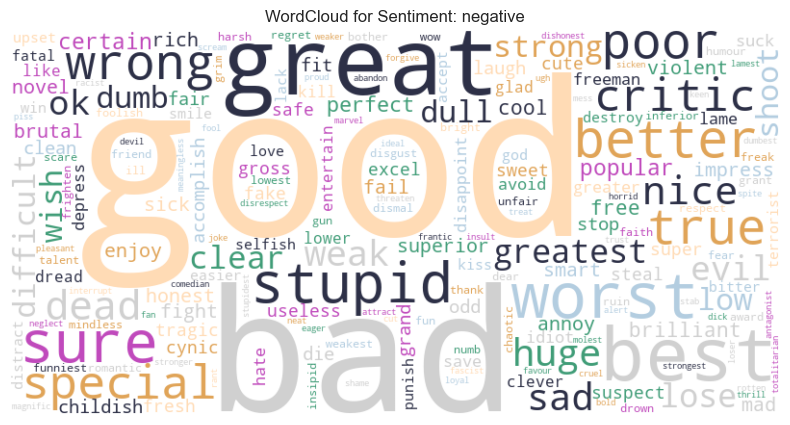

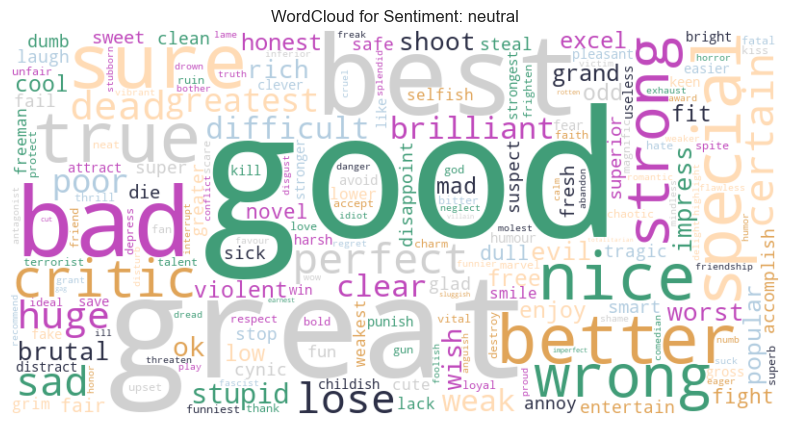

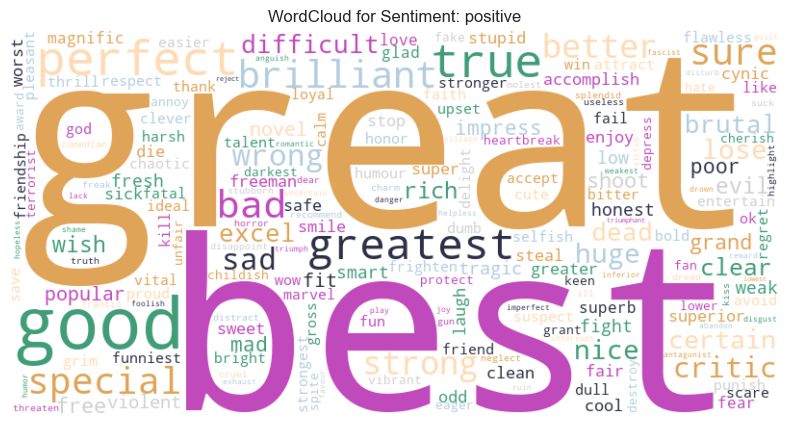

In [ ]:
# Generate word clouds for each sentiment category
from collections import Counter
# Get unique categories in 'status'
labels = df_eda_text['label'].unique()
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']
# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)


for label in labels:
    
    filtered_df = df_eda_text[(df_eda_text['label'] == label)]
    all_adjectives_list = filtered_df.explode('adjectives')['adjectives'].tolist()
    
    word_freq = Counter(all_adjectives_list)
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        color_func=color_func
    ).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  
    plt.title(f'WordCloud for Sentiment: {label}')
    plt.show()


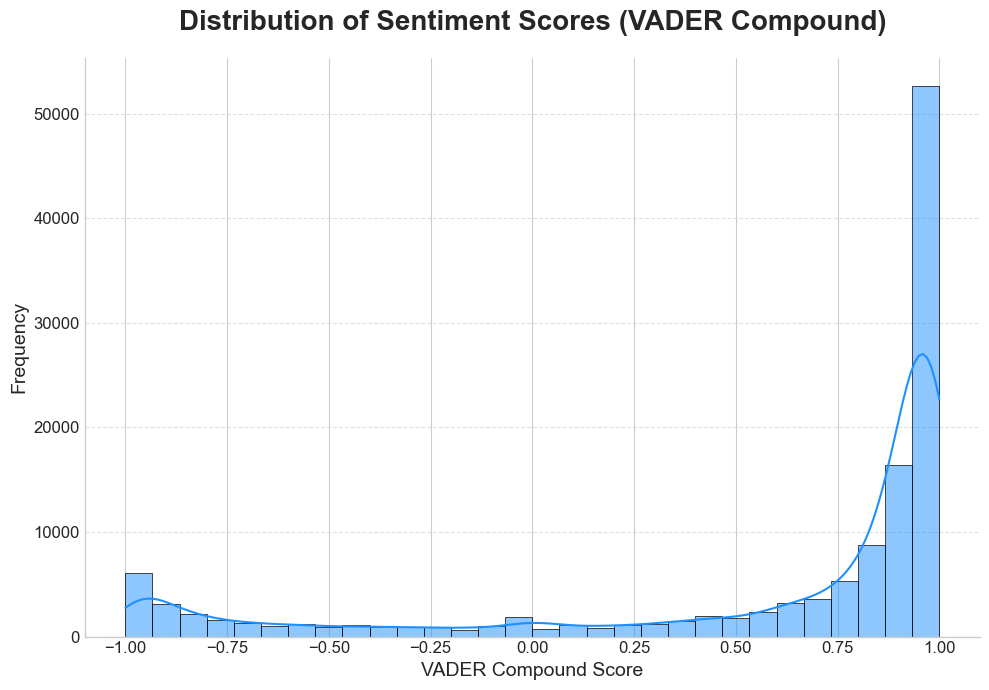

In [ ]:
# Set chart style and colors
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(figsize=(10, 7))

# Draw histogram and KDE (kernel density estimation) curve
sns.histplot(
    df_eda_text['score_compound'],
    bins=30,  # Increase number of bins for smoother distribution
    kde=True,
    color='#1E90FF',  # More professional blue color
    edgecolor='black',
    linewidth=0.5,
    ax=ax
)

# Set title and labels
ax.set_title('Distribution of Sentiment Scores (VADER Compound)', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('VADER Compound Score', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Adjust tick marks and grid lines
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Remove unnecessary borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

## 2 EDA for Top 250 Movies

In [41]:
final_df.columns

Index(['movie_rank', 'movie_title', 'movie_year', 'movie_country',
       'movie_rating', 'movie_genre', 'review_title', 'review_rating',
       'review_content', 'label', 'split', 'stemmed_review_title',
       'stemmed_review_content', 'review', 'score_compound'],
      dtype='object')

In [ ]:
# Prepare movie data for EDA by removing duplicates
df_eda = final_df.copy()
df_eda = df_eda[['movie_rank', 'movie_title', 'movie_year', 'movie_country','movie_rating', 'movie_genre']]
df_eda.drop_duplicates(inplace=True)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 0 to 3106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_rank     250 non-null    int64  
 1   movie_title    250 non-null    object 
 2   movie_year     250 non-null    int64  
 3   movie_country  250 non-null    object 
 4   movie_rating   250 non-null    float64
 5   movie_genre    250 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 13.7+ KB


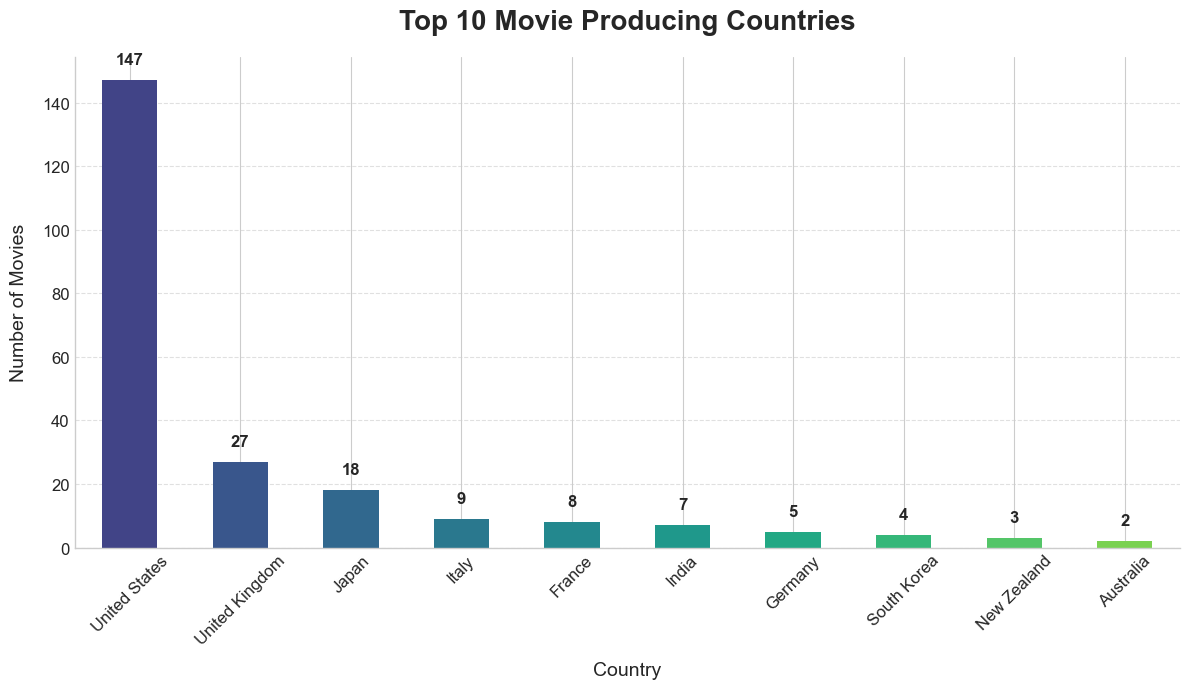

In [ ]:
# Create bar chart for top 10 movie producing countries
df_subset3 = df_eda.groupby('movie_country').size().sort_values(ascending=False).head(10)
# Set chart style
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Custom color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_subset3)))

# Draw bar chart
df_subset3.plot(kind='bar', color=colors, ax=ax, rot=45)

# Remove unnecessary borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set title and labels
ax.set_title('Top 10 Movie Producing Countries', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Country', fontsize=14, labelpad=10)
ax.set_ylabel('Number of Movies', fontsize=14, labelpad=10)
ax.tick_params(axis='both', labelsize=12)

# Add value labels on bars
for i, v in enumerate(df_subset3):
    ax.text(i, v + 5, str(v), ha='center', fontweight='bold', fontsize=12)

# Adjust grid line style
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Ensure compact layout
plt.tight_layout()
plt.show()

/var/folders/6w/dc0f1xpd3bs4_rlqgymllpww0000gn/T/ipykernel_61267/2669360428.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_subset = df_eda.groupby('year_range', as_index= False).agg(


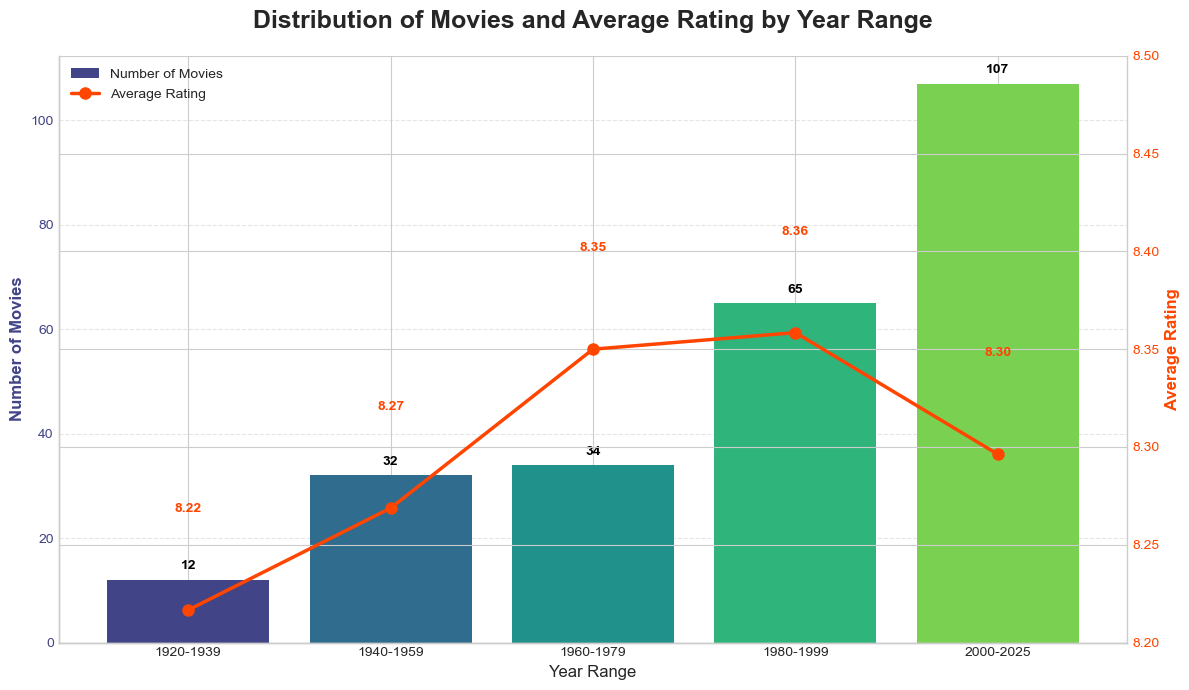

In [ ]:
# Create year range bins and analyze movie distribution and ratings by decade
df_eda['year_range'] = pd.cut(df_eda['movie_year'], bins=[1920, 1940, 1960, 1980, 2000, 2026], labels=['1920-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2025'], right=False)
df_subset = df_eda.groupby('year_range', as_index= False).agg(
    num_movies=('movie_title', 'count'),
    avg_rating=('movie_rating', 'mean')
)


# Set global font and style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Create a figure and axes object
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Custom gradient colors for bar chart ---
# Use viridis color palette to generate gradient colors
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_subset['num_movies'])))

# --- Draw bar chart ---
ax1.bar(df_subset['year_range'], df_subset['num_movies'], color=colors, width=0.8, label='Number of Movies')
ax1.set_xlabel('Year Range', fontsize=12)
ax1.set_ylabel('Number of Movies', color=colors[0], fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=colors[0], labelsize=10)
ax1.set_title('Distribution of Movies and Average Rating by Year Range', fontsize=18, pad=20, fontweight='bold')

# --- Add value labels on bars ---
for i, v in enumerate(df_subset['num_movies']):
    ax1.text(i, v + 2, str(v), color='black', ha='center', fontweight='bold')

# --- Draw line chart ---
ax2 = ax1.twinx()
line_color = '#FF4500' # Eye-catching orange-red color
ax2.plot(df_subset['year_range'], df_subset['avg_rating'], color=line_color, marker='o', linestyle='-', linewidth=2.5, markersize=8, label='Average Rating')
ax2.set_ylabel('Average Rating', color=line_color, fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=line_color, labelsize=10)
ax2.set_ylim(bottom=8.2, top=8.5)

# --- Add value labels on line chart ---
for i, v in enumerate(df_subset['avg_rating']):
    ax2.text(i, v + 0.05, f'{v:.2f}', color=line_color, ha='center', fontweight='bold', fontsize=10)

# --- Optimize chart appearance ---
ax1.grid(axis='y', alpha=0.5, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Unified legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

In [ ]:
# Create top 10 movie genres and counts using FreqDist
df_genre_list = df_eda[['movie_title', 'movie_genre']].drop_duplicates().reset_index(drop=True)['movie_genre'].to_list()
genre_list = []
for df_genre in  df_genre_list:
    for word in df_genre.split(','):
        genre_list.append(word.strip())
fqdt = nltk.FreqDist(genre_list)
fqdt



FreqDist({'Drama': 184, 'Adventure': 64, 'Crime': 53, 'Action': 49, 'Comedy': 44, 'Mystery': 31, 'Biography': 28, 'Animation': 28, 'Thriller': 27, 'War': 25, ...})

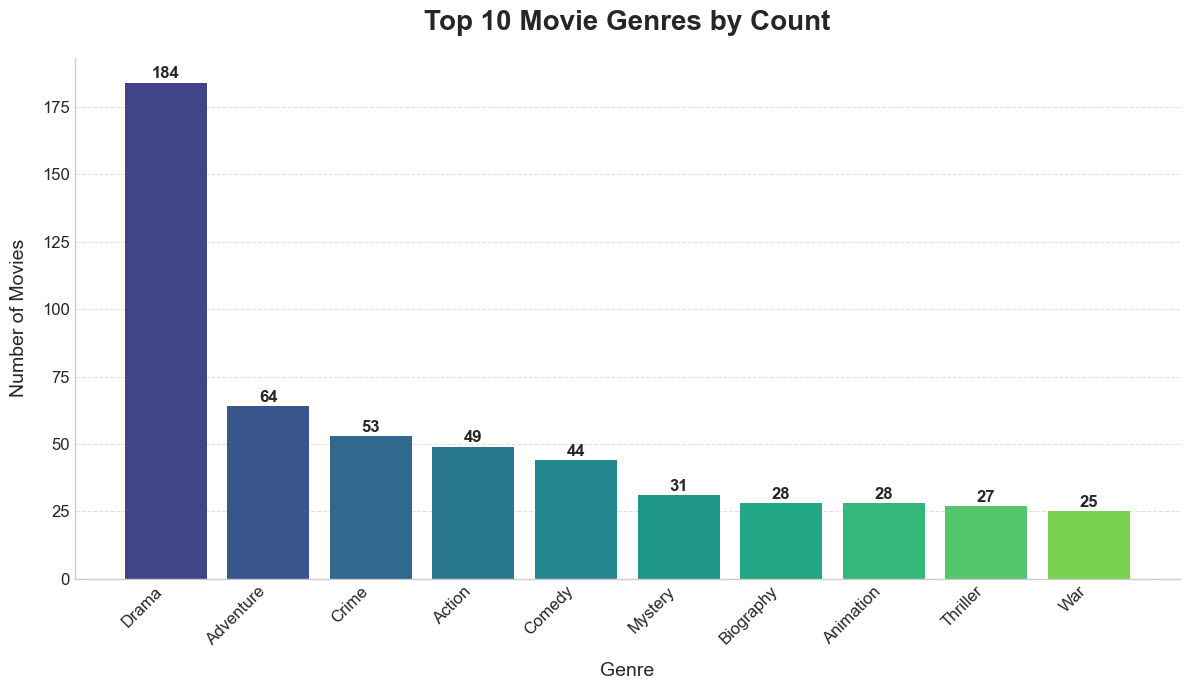

In [ ]:
# Analyze and visualize top 10 movie genres by count
df_genre_list = df_eda[['movie_title', 'movie_genre']].drop_duplicates().reset_index(drop=True)['movie_genre'].to_list()
genre_list = []
for df_genre in  df_genre_list:
    for word in df_genre.split(','):
        genre_list.append(word.strip())
fqdt = nltk.FreqDist(genre_list)

top_10_genres = fqdt.most_common(10)
genres = [item[0] for item in top_10_genres] # Genre names
counts = [item[1] for item in top_10_genres] # Counts

# --- Plotting settings ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# *** Key modification 2: Custom color palette, number of colors equals Top 10 count ***
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_10_genres)))

# *** Key modification 3: Draw bar chart using extracted Top 10 data ***
# Use ax.bar() instead of fqdt.plot() for finer control
bars = ax.bar(genres, counts, color=colors)

# Remove unnecessary borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set title and labels
ax.set_title('Top 10 Movie Genres by Count', fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Genre', fontsize=14, labelpad=10)
ax.set_ylabel('Number of Movies', fontsize=14, labelpad=10)
ax.tick_params(axis='both', labelsize=12)

# Rotate X-axis labels
plt.xticks(rotation=45, ha='right')

# *** Key modification 4: Add value labels on bars using Top 10 data ***
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, int(yval), 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Adjust grid line style
ax.grid(axis='y', linestyle='--', alpha=0.6)
# Remove X-axis grid lines
ax.grid(axis='x', which='both', visible=False)

# Ensure compact layout
plt.tight_layout()
plt.show()

### Machine Learning

### 3.1 Review Sentiment Classification

In [ ]:
# Prepare data for machine learning by selecting relevant features
df_ml = final_df.copy()
df_ml = df_ml[['review_title', 'review_content', 'score_compound' ,'review', 'label', 'split']]

In [ ]:
# Encode categorical labels to numerical values for machine learning
lbl_enc = LabelEncoder()
df_ml['label'] = lbl_enc.fit_transform(df_ml['label'].values)

original_labels = lbl_enc.classes_
encoded_labels = np.arange(len(original_labels))

zipped_pairs = zip(encoded_labels, original_labels)
label_map = dict(zipped_pairs)

label_map

{0: 'negative', 1: 'neutral', 2: 'positive'}

In [ ]:
# Create TF-IDF vectors as features and combine with VADER sentiment scores
#TF-IDF Vectors as features
#Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

X_train = df_ml[df_ml['split'] == 'train'][['review', 'score_compound']]
y_train = df_ml[df_ml['split'] == 'train']['label']
X_test = df_ml[df_ml['split'] == 'test'][['review', 'score_compound']]
y_test = df_ml[df_ml['split'] == 'test']['label']


tfidf_vect = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
xtrain_tfidf =  tfidf_vect.fit_transform(X_train['review'].apply(lambda x: ' '.join(x)))
xtest_tfidf =  tfidf_vect.transform(X_test['review'].apply(lambda x: ' '.join(x)))
X_train_combined = hstack([xtrain_tfidf,X_train[['score_compound']].values])
X_test_combined = hstack([xtest_tfidf,X_test[['score_compound']].values])

In [ ]:
# Check class distribution in training data
y_train.value_counts()

label
2    66031
1    17019
0     6113
Name: count, dtype: int64

In [ ]:
# Apply SMOTE (Synthetic Minority Oversampling Technique) to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)
y_train_resampled.value_counts()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


label
0    66031
1    66031
2    66031
Name: count, dtype: int64

In [ ]:
# Prepare class names for evaluation metrics
text_y_decode = [label_map[i] for i in y_test]
class_names = ['negative', 'neutral', 'positive']

In [ ]:
# Define function to train and evaluate multiple machine learning models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models with optional class balancing
    """
    results = {}
    
    # 1. Logistic Regression with balanced class weights
    print("\n" + "="*50)
    print("TRAINING LOGISTIC REGRESSION MODEL (BALANCED)")
    print("="*50)
    
    lr_model = LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced' 
    )
    lr_model.fit(X_train, y_train)

    predictions = lr_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)

    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- LOGISTIC REGRESSION  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)

    results['Logistic Regression (Balanced)'] = {
    'model': lr_model,
    'predictions': predictions,
    'accuracy': accuracy
    }
    
    # 2. Random Forest with balanced class weights
    print("\n" + "="*50)
    print("TRAINING RANDOM FOREST MODEL (BALANCED)")
    print("="*50)
    
    rf_model = RandomForestClassifier(
            class_weight='balanced', 
            random_state=42, 
            n_estimators=300
            )
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances_
    predictions = rf_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)
    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- RANDOM FOREST  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)
    print(f"\n--- Feature Importance  ---")
    print(importances)

    results['Random Forest (Balanced)'] = {
    'model': rf_model,
    'predictions': predictions,
    'accuracy': accuracy
    }


    # 3. XGBoost
    print("\n" + "="*50)
    print("TRAINING XGBoost MODEL (Balanced)")
    print("="*50)
    
    xb_model = XGBClassifier(
        random_state=42,
        n_estimators=300,
        eval_metric='logloss'
    ) 
    xb_model.fit(X_train, y_train)
    
    predictions = xb_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)
    
    predictions_decode = [label_map[i] for i in predictions]
    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- XGBoost  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)

    results['XGBoost (Balanced)'] = {
    'model': xb_model,
    'predictions': predictions,
    'accuracy': accuracy
    }
    
    return results

In [ ]:
# Define function to plot confusion matrices for model evaluation
def plot_confusion_matrices(y_test, results):
    """
    Plot confusion matrices for both models
    """
    num_models = len(results)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))
    
    # Handle the case where there is only one model so axes isn't an array
    if num_models == 1:
        axes = [axes]

    for i, (model_name, result) in enumerate(results.items()):
        cm = metrics.confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['negative', 'neutral', 'positive'],
                   yticklabels=['negative', 'neutral', 'positive'],
                   ax=axes[i])
        axes[i].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.4f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Define function to plot feature importance for XGBoost model
def plot_feature_importance(xb_model, top_n):
    """
    Plot tree and feature importance for XGBoost
    """

    importance_scores = xb_model.get_booster().get_score(importance_type='total_gain')
    tfidf_names = list(tfidf_vect.get_feature_names_out())
    manual_feature_names = ['score_compound']

    feature_names = tfidf_names + manual_feature_names

    # Convert to DataFrame for easier processing
    import pandas as pd
    feature_df = pd.DataFrame(
        list(importance_scores.items()), 
        columns=['Feature', 'Importance']
    )
    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(top_n)

    def map_feature_name(f_index):
        # f_index format is 'f0', 'f1', ...
        index = int(f_index[1:])
        return feature_names[index]

    feature_df['Feature Name'] = feature_df['Feature'].apply(map_feature_name)

    import seaborn as sns
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')
    plt.title("XGBoost - Feature Importance" \
    "", fontsize=16)
    plt.show()


In [59]:
# Train and evaluate models with class balancing
results = train_and_evaluate_models(X_train_resampled, X_test_combined, y_train_resampled, y_test)



TRAINING LOGISTIC REGRESSION MODEL (BALANCED)

--- LOGISTIC REGRESSION  ---
accuracy: 0.7668
              precision    recall  f1-score   support

    negative       0.47      0.71      0.57      2620
     neutral       0.47      0.62      0.53      7294
    positive       0.93      0.81      0.87     28299

    accuracy                           0.77     38213
   macro avg       0.62      0.71      0.66     38213
weighted avg       0.81      0.77      0.78     38213


TRAINING RANDOM FOREST MODEL (BALANCED)

--- RANDOM FOREST  ---
accuracy: 0.8186
              precision    recall  f1-score   support

    negative       0.76      0.50      0.60      2620
     neutral       0.62      0.48      0.54      7294
    positive       0.86      0.93      0.89     28299

    accuracy                           0.82     38213
   macro avg       0.75      0.64      0.68     38213
weighted avg       0.81      0.82      0.81     38213


--- Feature Importance  ---
[4.79499701e-05 3.64168901e-05 9.

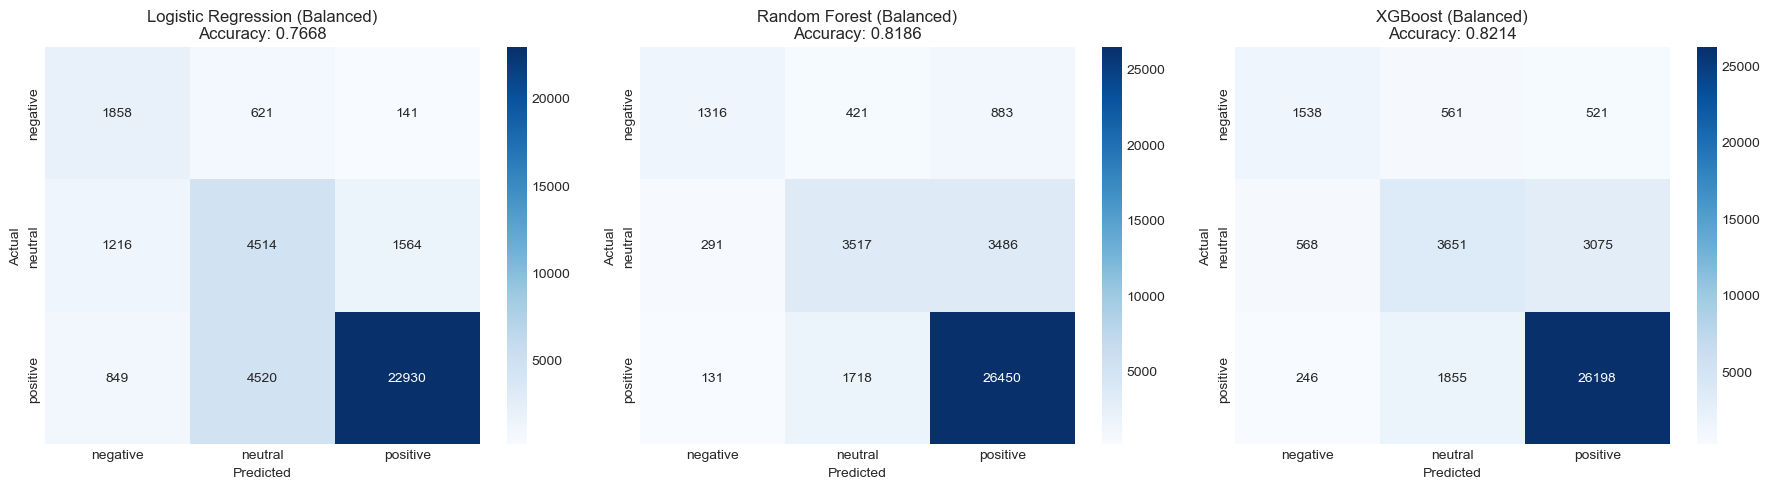

/var/folders/6w/dc0f1xpd3bs4_rlqgymllpww0000gn/T/ipykernel_61267/1090634304.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')


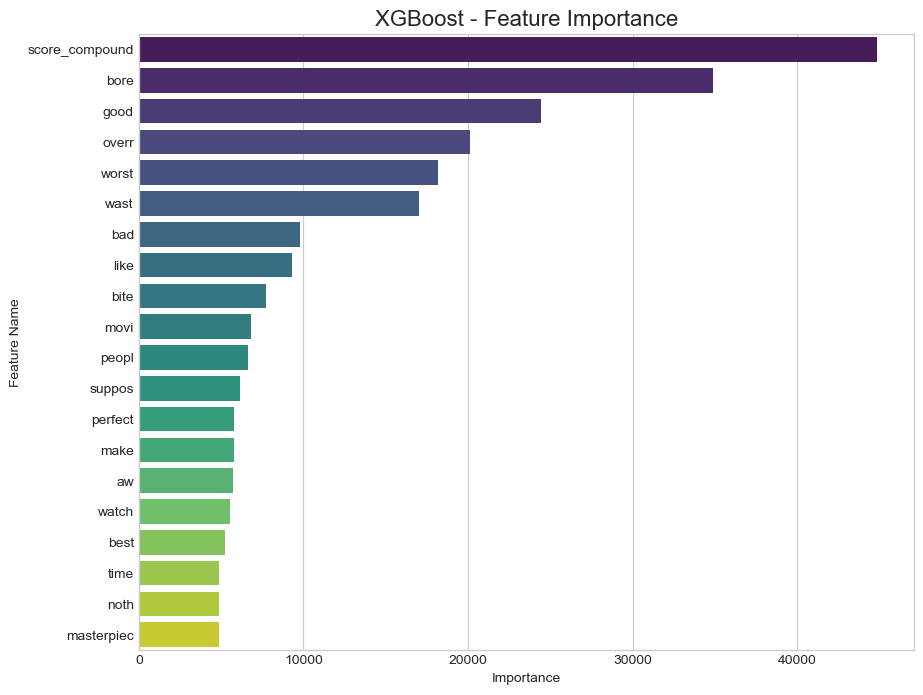

In [ ]:
# Plot confusion matrices and feature importance for model evaluation
plot_confusion_matrices(y_test, results)
plot_feature_importance(results['XGBoost (Balanced)']['model'], 20)

In [ ]:
# Display final results summary and identify best performing model
# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print()
    
# Model comparison
best_model_accuracy = max(results.items(), key=lambda x: x[1]['accuracy'])

print(f"Best performing model by accuracy: {best_model_accuracy[0]} ({best_model_accuracy[1]['accuracy']:.4f})")


FINAL RESULTS SUMMARY
Logistic Regression (Balanced):
  Accuracy: 0.7668

Random Forest (Balanced):
  Accuracy: 0.8186

XGBoost (Balanced):
  Accuracy: 0.8214

Best performing model by accuracy: XGBoost (Balanced) (0.8214)
